In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dbscan_cluster import run_dbscan
from cluster_utils import cluster_plot, cluster_plot_galactic
import json

from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from simbad_download import resolve_name

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
CLUSTER_NAME: str = 'NGC 188'

In [3]:
gaiadr3 = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
normalized = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized.dat')
normalized_cp = np.loadtxt(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_normalized_cp.dat')
lit = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_literature.csv')

In [4]:
lit_dr3 = pd.merge(left=lit[['EDR3 id', 'reported', 'TIC']], right=gaiadr3, left_on='EDR3 id', right_on='source_id', how='inner')

In [5]:
cp_ra, cp_dec, cp_par, cp_pmra, cp_pmdec, cp_radvel = resolve_name(CLUSTER_NAME)

In [6]:
galactic_coords = SkyCoord(ra=cp_ra*u.deg, dec=cp_dec*u.deg,
                           pm_ra_cosdec=cp_pmra*u.mas/u.year, frame=ICRS,
                           pm_dec=cp_pmdec*u.mas/u.year).galactic

In [7]:
galactic_coords

<SkyCoord (Galactic): (l, b) in deg
    (122.8367566, 22.37303701)
 (pm_l_cosb, pm_b) in mas / yr
    (-2.32538677, -0.91518539)>

# Plain DBSCAN

In [10]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_best_params.json', 'r') as f:
    best_params = json.load(f)

In [11]:
best_params

{'best_value': 1.0500193666734279,
 'best_params': {'eps': 0.16926266909753007, 'min_samples': 31}}

In [68]:
clustered, noise, found, not_found = run_dbscan(normalized, gaiadr3, lit_dr3, 0.22, 8, False)

Classified into 300 labels.
Clustered: 857/957
857/957 sources from literature clustered
1413 clustered sources.


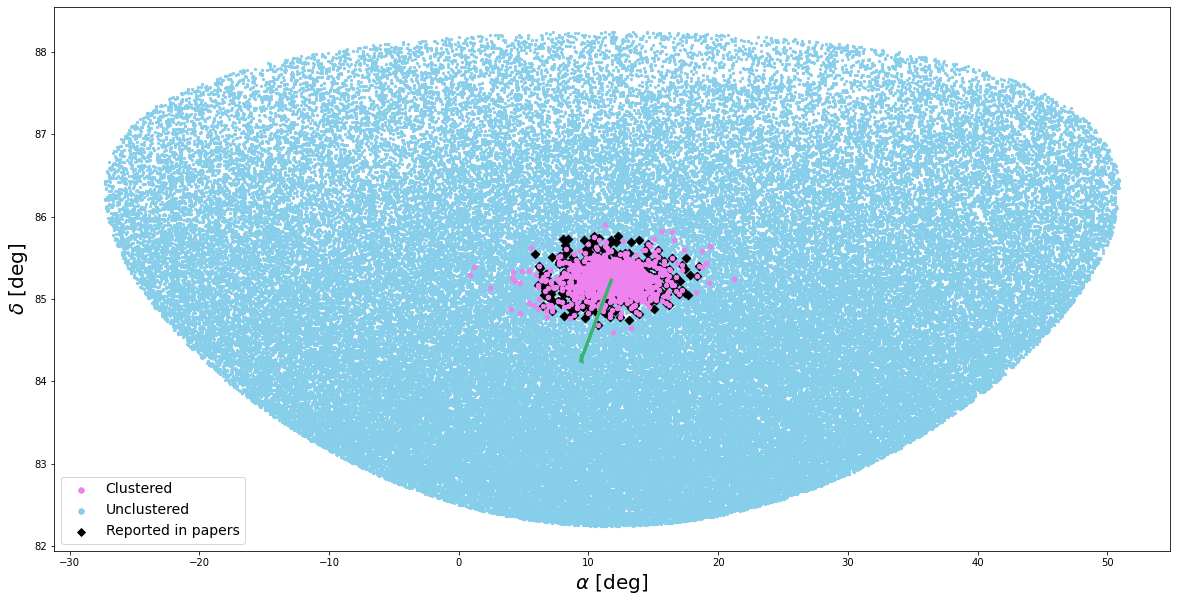

In [66]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

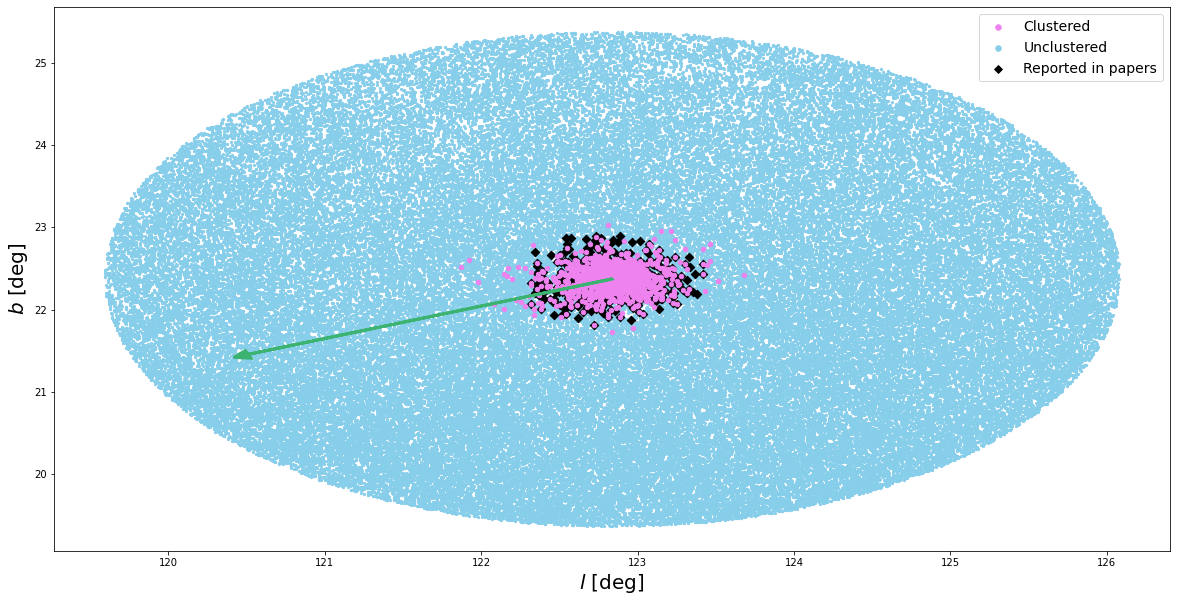

In [67]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [69]:
clustered.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
not_found.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_not_found.csv')

# Convergent velocities

In [8]:
with open(f'optuna_db/{CLUSTER_NAME}/{CLUSTER_NAME.replace(" ", "_")}_cp_best_params.json', 'r') as f:
    best_params = json.load(f)

In [9]:
best_params

{'best_value': 0.9663642310523731,
 'best_params': {'eps': 0.0900667918372248, 'min_samples': 42}}

In [62]:
clustered, noise, _, _ = run_dbscan(normalized_cp, gaiadr3, lit_dr3, 0.11, 20, False)

Classified into 6 labels.
Clustered: 779/957
779/957 sources from literature clustered
1423 clustered sources.


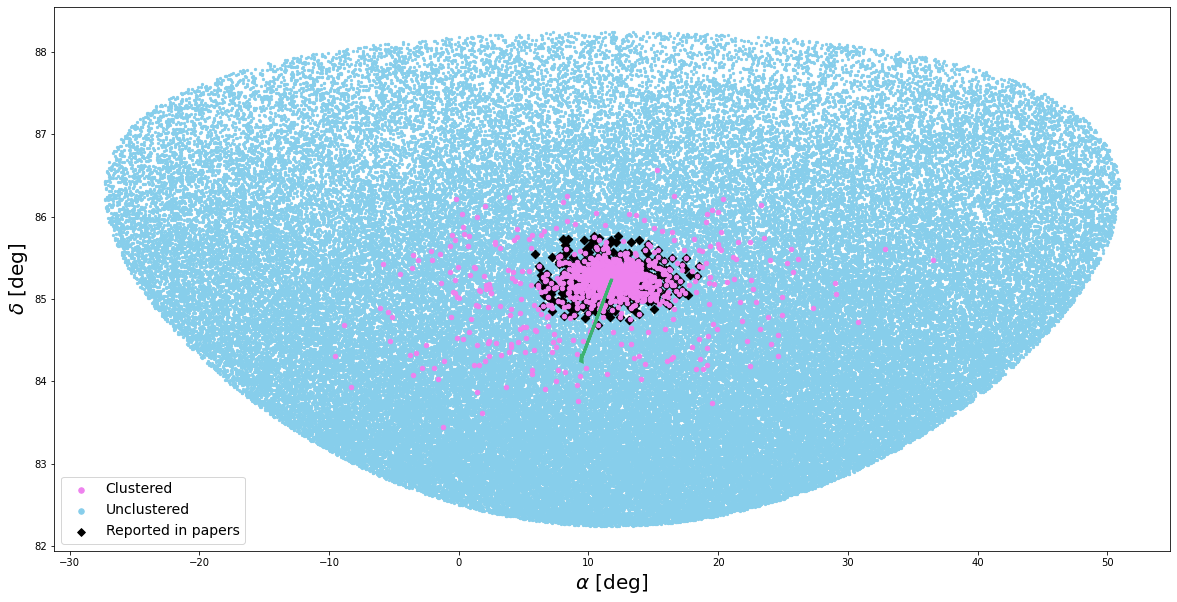

In [63]:
cluster_plot(clustered, gaiadr3, lit_dr3)
plt.arrow(cp_ra,
          cp_dec,
          cp_pmra,
          cp_pmdec,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

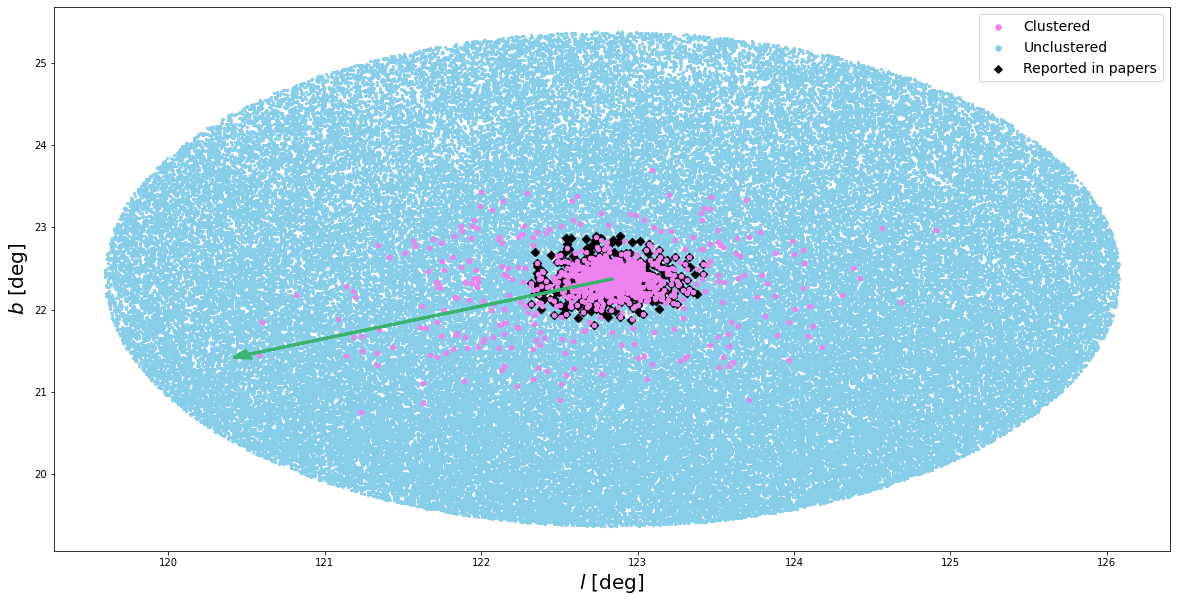

In [64]:
cluster_plot_galactic(clustered, gaiadr3, lit_dr3)
plt.arrow(galactic_coords.l.value,
          galactic_coords.b.value,
          galactic_coords.pm_l_cosb.value,
          galactic_coords.pm_b.value,
          linewidth=3.,
          color='mediumseagreen',
          head_width=0.1,
          head_length=0.1,
          zorder=4)

In [13]:
a = np.loadtxt('Trumpler 5_isochrone.dat', usecols=(28, 29, 30))

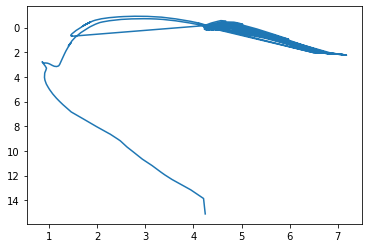

In [14]:
plt.plot(a[:-1, 1]-a[:-1, 2], a[:-1, 0])
plt.gca().invert_yaxis();